In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, GPT2LMHeadModel

/Users/inar/.local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [5]:
text1 = "Tom and Lily were playing with their toys in the living room. They liked to build towers and bridges with their blocks and cars. "
text2 = "These functions will work with the hidden states output from a model like GPT-2 to give you the probability distribution and the entropy of that distribution. "

In [6]:
inputs = tokenizer(text2, return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)


In [7]:
def count_outliers(hidden_states, threshold = 5.0):
    # Convert the hidden states to absolute values
    abs_hidden_states = torch.abs(hidden_states)
    # Check if the hidden states exceed the threshold
    outliers = abs_hidden_states > threshold
    # Count the number of times the threshold is exceeded, summing over both batch and sequence dimensions
    count = torch.sum(outliers, dim=(0, 1))  # This will sum across batch and sequence lengths
    return count

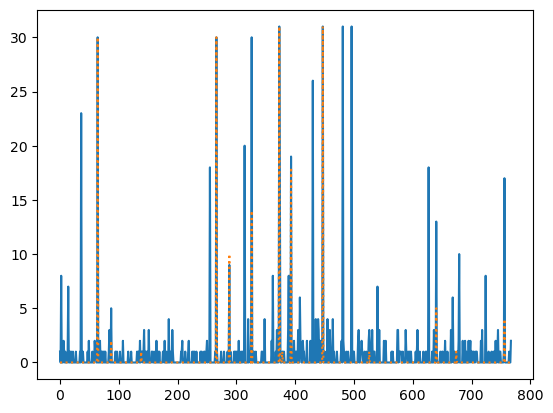

In [8]:

plt.plot(count_outliers(outputs.hidden_states[11],10))
plt.plot(count_outliers(outputs.hidden_states[2],10), ':')

In [9]:

# Function to count the outliers in the hidden states
def count_outliers(hidden_states, threshold, abs = True):
    # Convert the hidden states to absolute values
    abs_hidden_states = torch.abs(hidden_states)
    # Check if the hidden states exceed the threshold
    if abs:
        outliers = abs_hidden_states > threshold
    else:
        outliers = hidden_states > threshold

    # Count the number of times the threshold is exceeded, summing over both batch and sequence dimensions
    count = torch.sum(outliers, dim=(0, 1))  # This will sum across batch and sequence lengths
    return count

# Function to process a single text and return the outlier counts per layer
def process_text(text, model, tokenizer, threshold, abs = True):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():  # Deactivate gradients for efficiency
        outputs = model(**inputs, output_hidden_states=True)

    # Get the hidden states
    hidden_states = outputs.hidden_states  # Tuple of length `num_hidden_layers`

    # Initialize a list to hold the counts for each layer
    counts_per_layer = [torch.zeros(model.config.n_embd) for _ in range(model.config.num_hidden_layers+1)]

    # Iterate over each layer's hidden states and update counts
    for i, layer_hidden_states in enumerate(hidden_states):
        counts_per_layer[i] += count_outliers(layer_hidden_states, threshold, abs=abs)
    
    return counts_per_layer


# accumulated_counts now holds the total count of outlier activations per component for each layer


In [10]:
def split_text_into_token_chunks(text, max_length, tokenizer):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Split the tokens into chunks that do not exceed max_length
    chunks = []
    current_chunk = []
    current_length = 0
    for token in tokens:
        current_chunk.append(token)
        current_length += 1
        if current_length == max_length:
            chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
            current_chunk = []
            current_length = 0
    # Don't forget to add the last chunk if it's not empty
    if current_chunk:
        chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
    return chunks




In [11]:
import requests
import random

# Function to fetch text from a URL
def fetch_text_from_url(url):
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to retrieve text from {url}, status code: {response.status_code}")

# URLs to fetch - replace these URLs with the actual Project Gutenberg URLs
urls = [
    'http://www.gutenberg.org/files/1342/1342-0.txt',  # Example: Pride and Prejudice by Jane Austen
    'http://www.gutenberg.org/cache/epub/11/pg11.txt',  # Example: Alice's Adventures in Wonderland by Lewis Carroll
]

In [12]:
max_length = 512 #tokenizer.model_max_length

# List to hold all the text chunks
text_chunks = []

# Fetch texts and split into chunks
for url in urls:
    text = fetch_text_from_url(url)
    # Optionally, clean and preprocess the text as needed
    # ...
    # Split the text into chunks suitable for GPT-2
    chunks = split_text_into_token_chunks(text, max_length, tokenizer)
    text_chunks.extend(chunks)

Token indices sequence length is longer than the specified maximum sequence length for this model (225798 > 1024). Running this sequence through the model will result in indexing errors


In [13]:
len(text_chunks)

546

In [14]:
# # Define the threshold for outlier detection
threshold = 15.0


accumulated_counts = [torch.zeros(model.config.n_embd) for _ in range(model.config.num_hidden_layers+1)]

# Process each text
random_sample_of_chunks = random.sample(text_chunks, 20)
for text in random_sample_of_chunks:
    # Get counts for the current text
    counts_per_layer = process_text(text, model, tokenizer, threshold, abs = False)
    
    # Accumulate the counts
    for i in range(len(accumulated_counts)):
        accumulated_counts[i] += counts_per_layer[i]


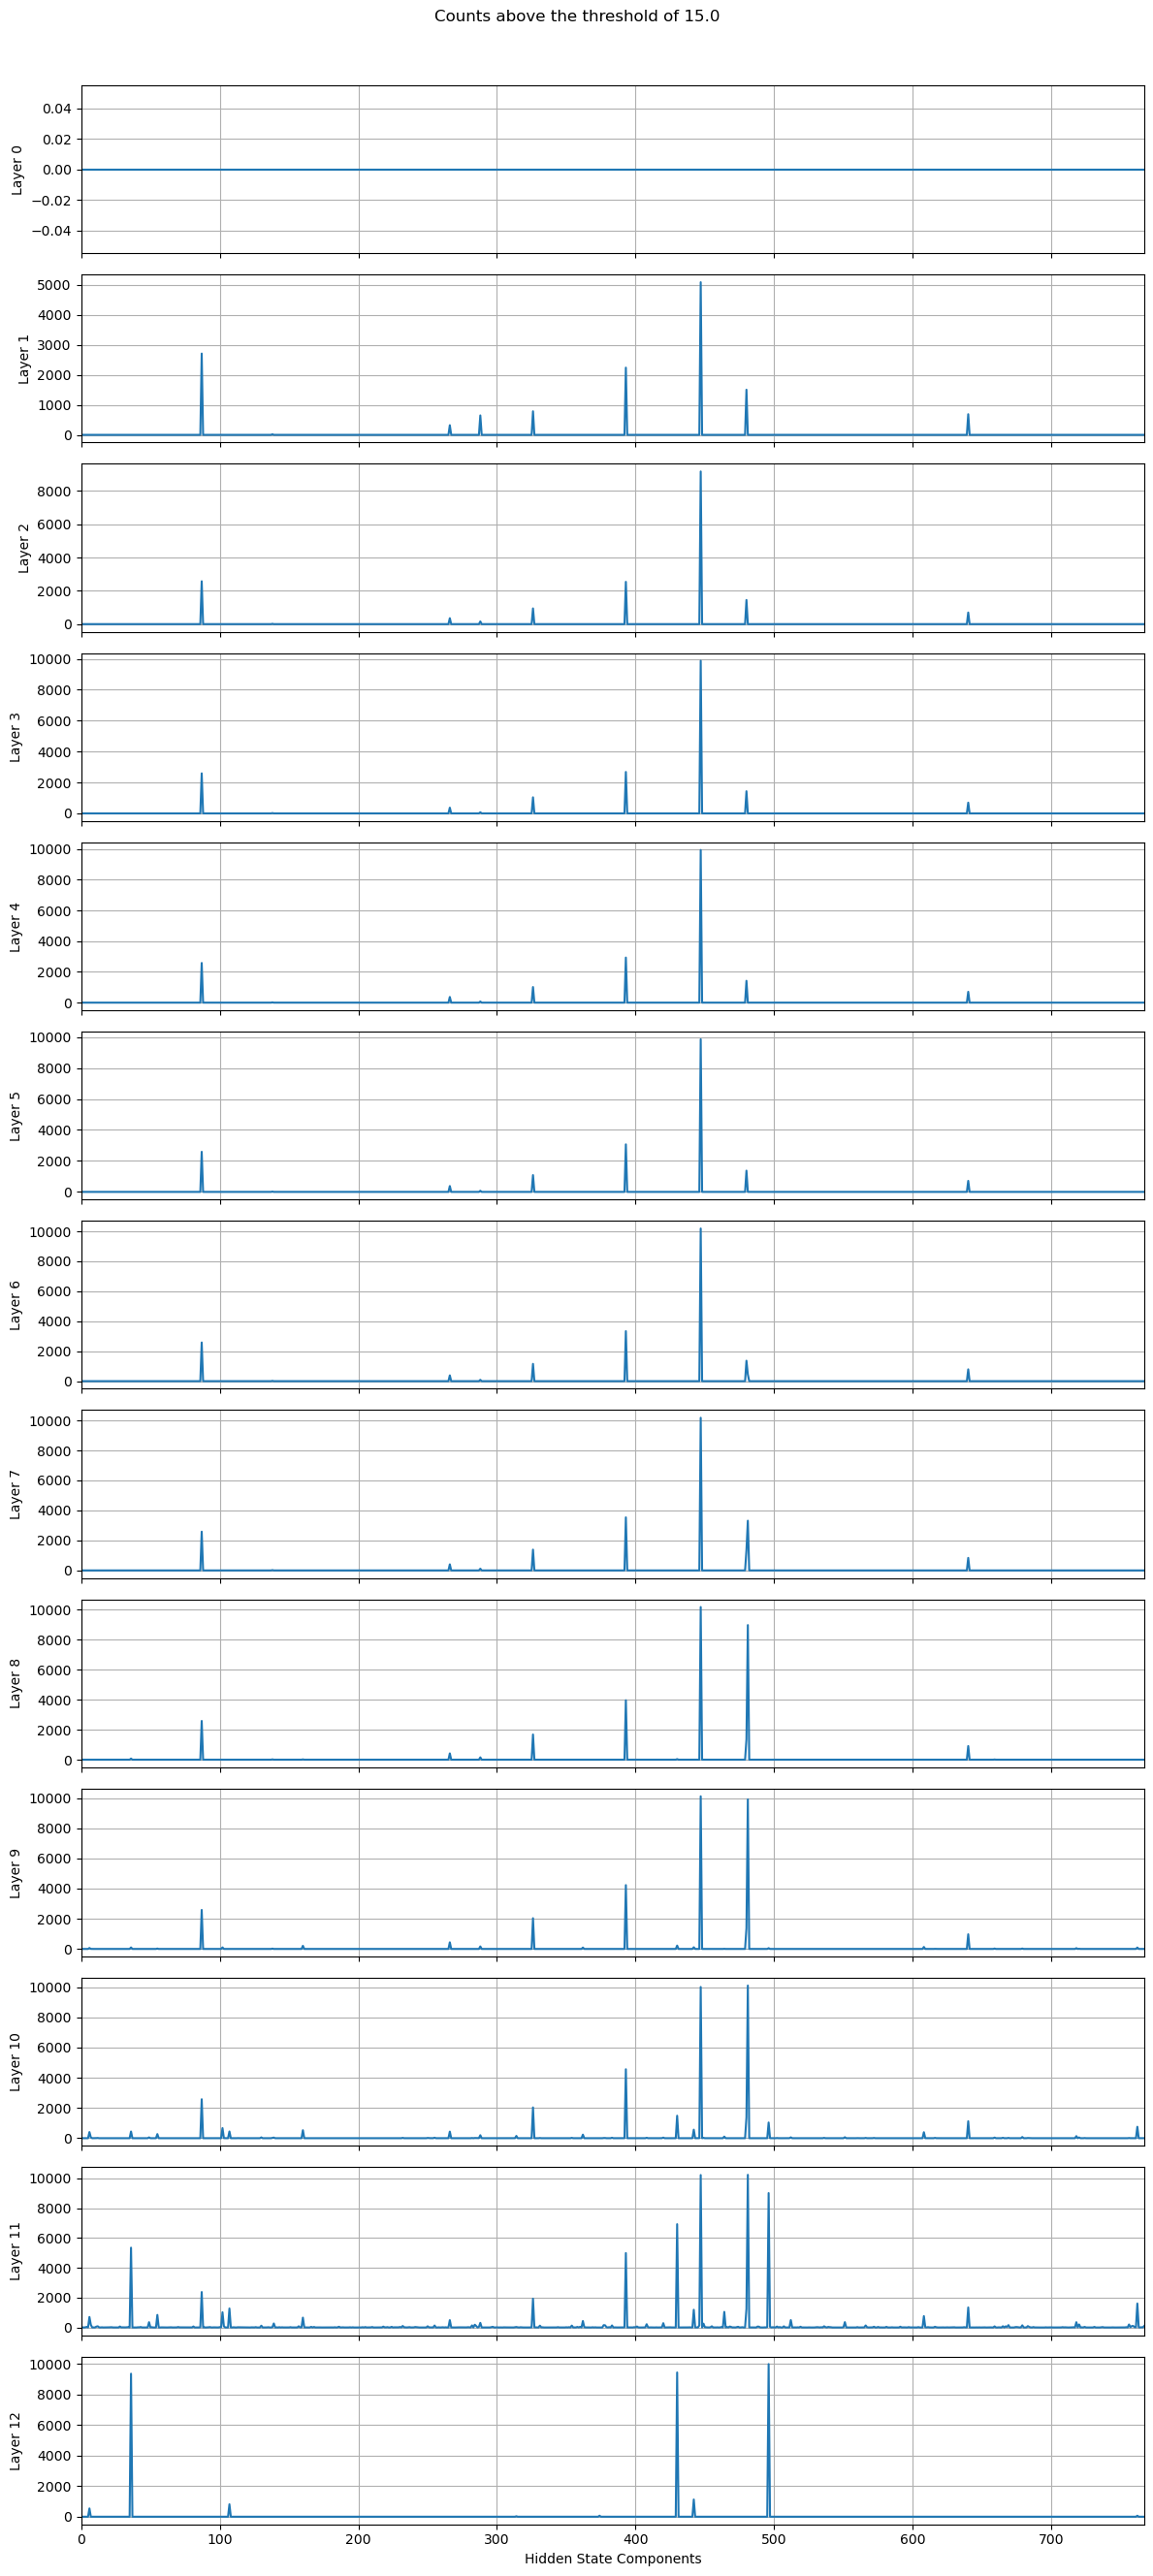

In [15]:
import matplotlib.pyplot as plt

n_layers = len(accumulated_counts)  # Assuming accumulated_counts is a list of counts for each layer
n_cols = 1  # Number of columns in the subplot grid
n_rows = n_layers  # Number of rows in the subplot grid

# Create a figure and a grid of subplots with a shared x-axis
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 2), sharex=True)

# If only one row/column, axs may not be a list, so we ensure it's iterable
if n_layers == 1:
    axs = [axs]

for i, counts in enumerate(accumulated_counts):
    countsl = counts.numpy()
    
    # Select the subplot for the current layer
    ax = axs[i]
    
    # Plot the data
    ax.plot(countsl)
    ax.set_ylabel(f'Layer {i}')  # Set common y-label
    ax.grid(True)
    
    # Set the x-axis limits from 0 to the number of components minus 1
    ax.set_xlim(0, 767)

# Set common attributes for all subplots
plt.suptitle(f'Counts above the threshold of {threshold}', y=1.02)

# Set the x-axis label only on the bottom subplot
axs[-1].set_xlabel('Hidden State Components')

# Adjust the layout so titles and labels don't overlap and provide space for the super title
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(top=0.99) 

plt.show()


In [16]:
inputs = tokenizer(text_chunks[20], return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)

In [17]:
outputs.hidden_states[0].shape

torch.Size([1, 512, 768])

In [18]:
outputs.logits.shape

torch.Size([1, 512, 50257])

In [ ]:
embedding_weight = model.get_input_embeddings().weight
unembed = embedding_weight.transpose(0, 1)

In [ ]:
import numpy as np
Wai=unembed.detach().numpy().T
pinvWai = np.linalg.pinv(Wai) 

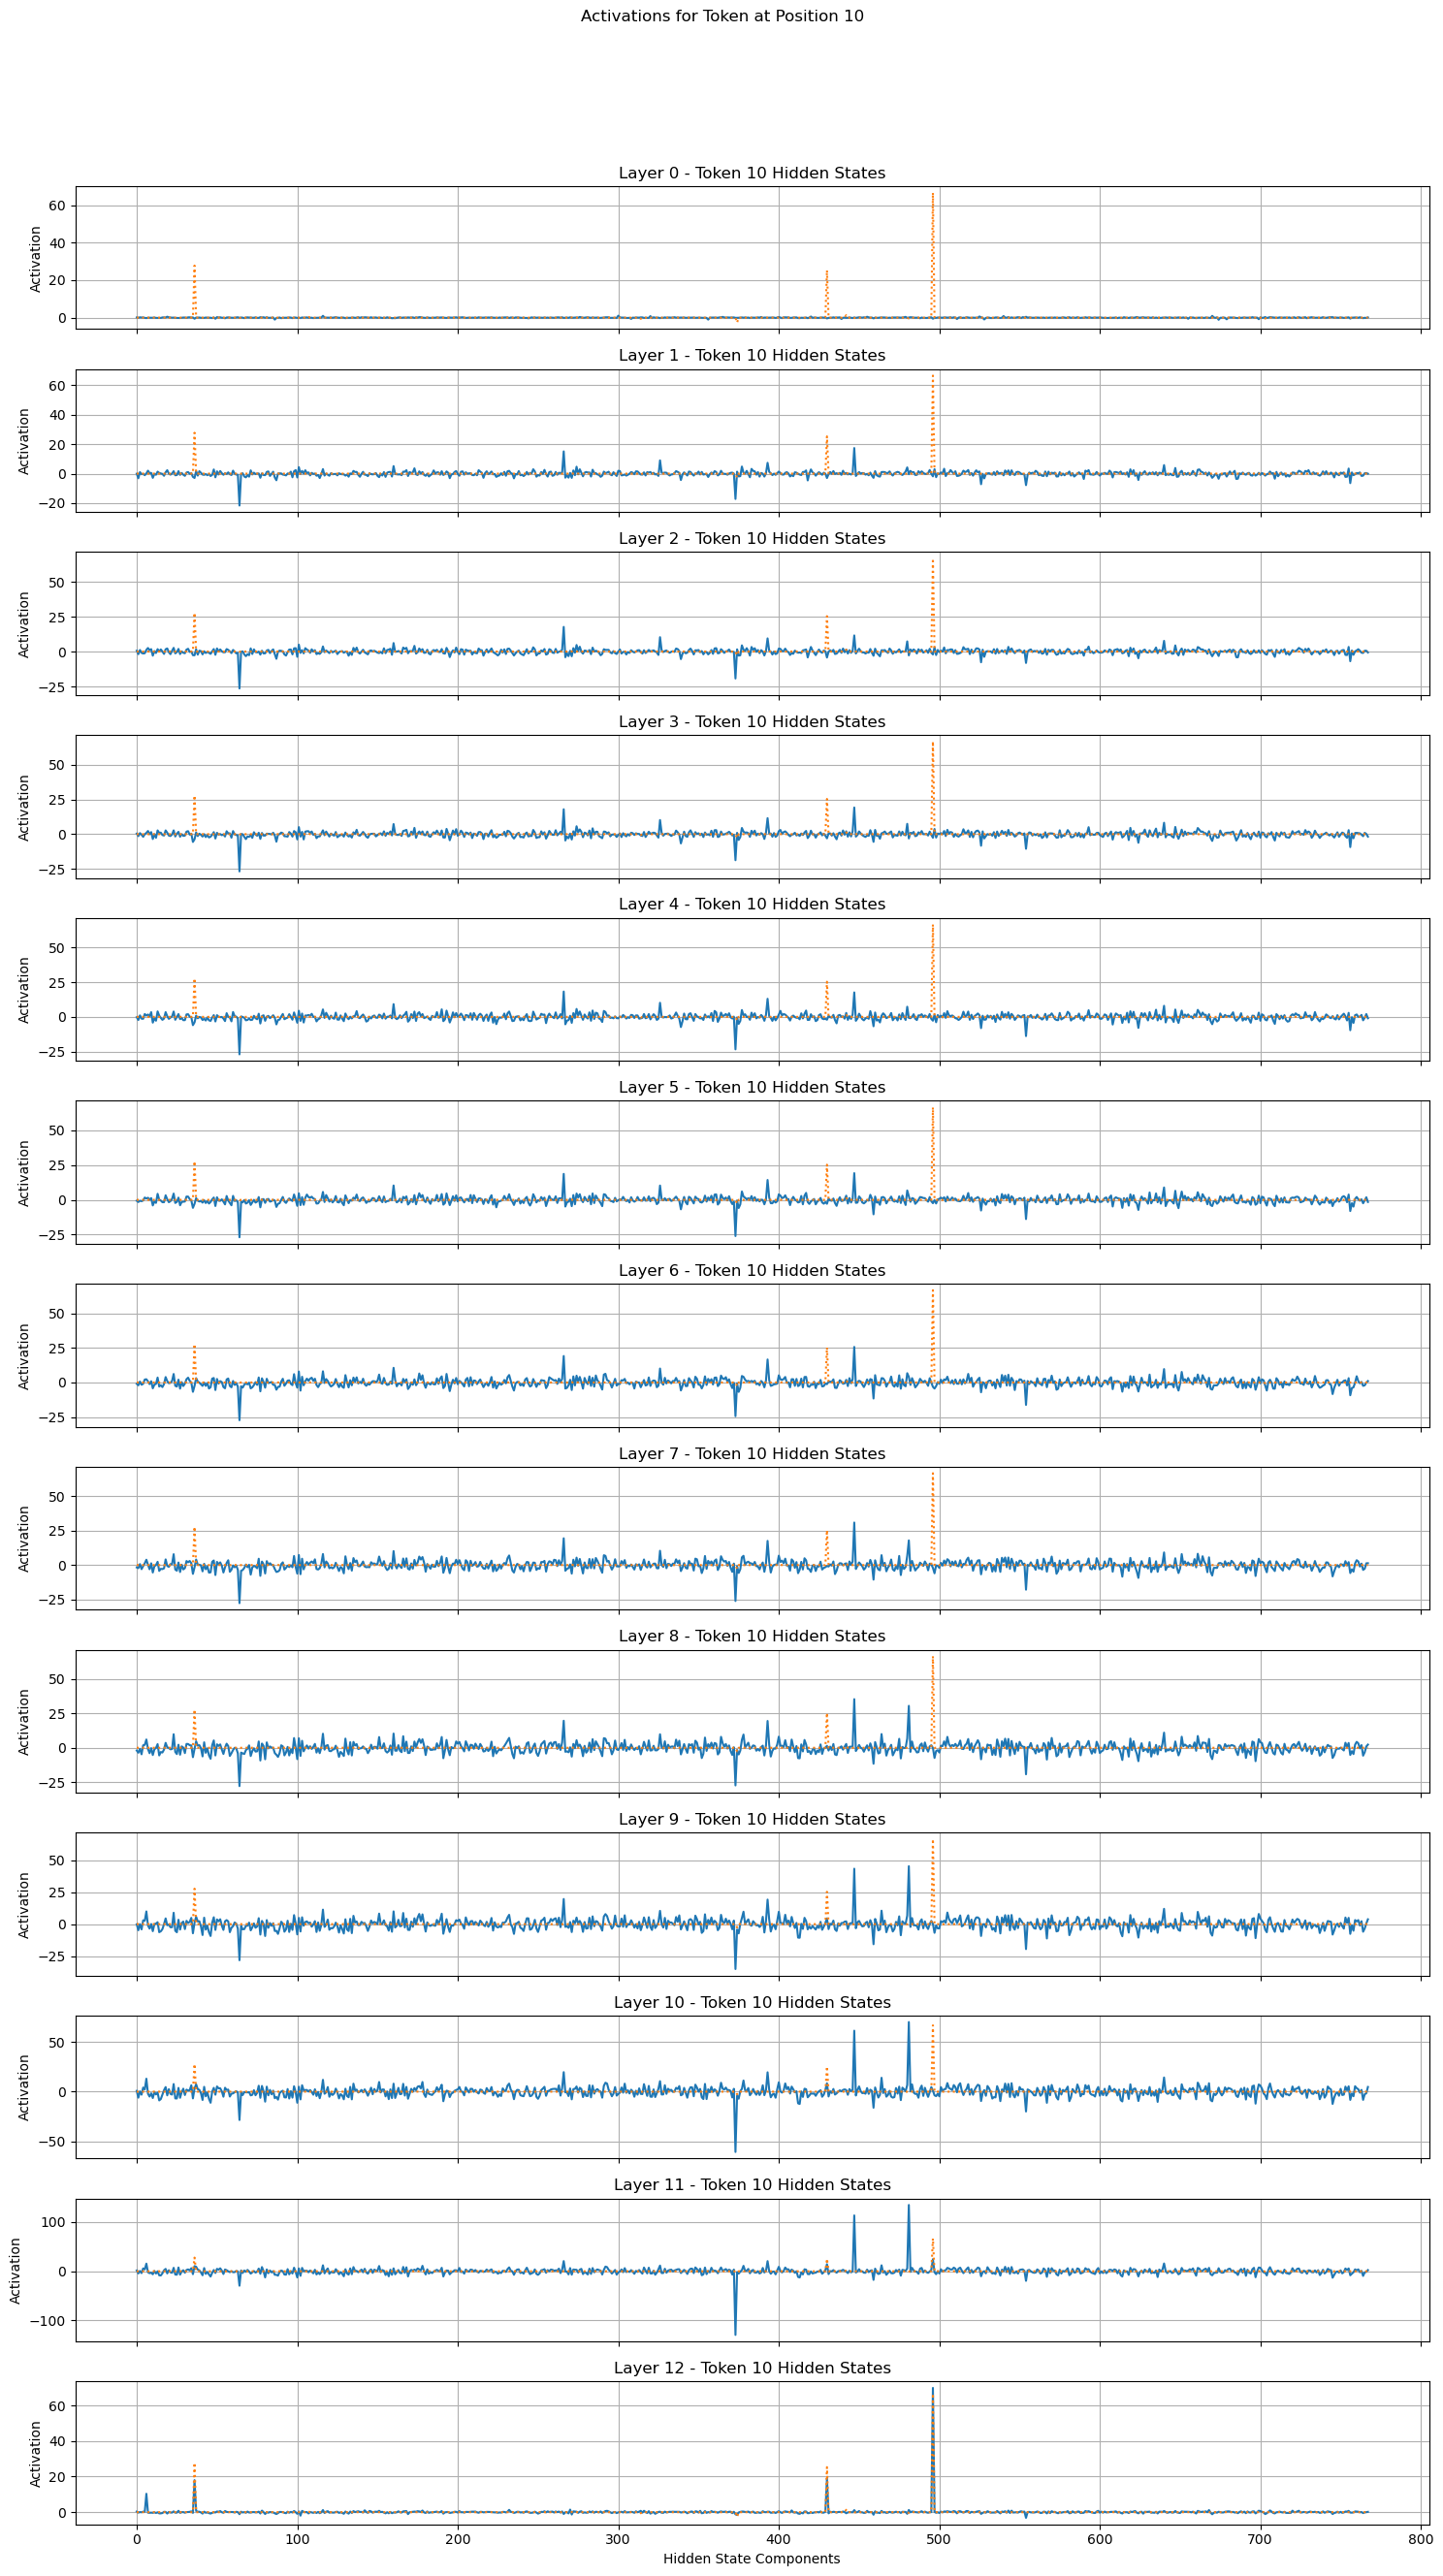

In [56]:

# Extract the hidden states
hidden_states = outputs.hidden_states

# Choose the token position k (e.g., k=10 for the eleventh token)
k = 10

# Determine the number of layers
n_layers = len(hidden_states)

# Set up the figure and array of subplots
fig, axs = plt.subplots(n_layers, 1, figsize=(15, n_layers * 2), sharex=True)

# Iterate over each layer to plot the hidden states for token k
for i, layer_hidden_states in enumerate(hidden_states):
    # Extract the hidden states for token k in this layer
    token_hidden_states = layer_hidden_states[0, k].detach().numpy()

    # Plot the hidden states for this layer
    
    # if i > 11:
    #     axs[i].plot(token_hidden_states+72*pinvWai @ np.ones(50257))
    # else:
    axs[i].plot(token_hidden_states)
    axs[i].plot(-30*pinvWai @ np.ones(50257), ':')
    # axs[i].plot(-72*pinvWai @ np.ones(50257), ':')
    # axs[i].plot(-72*pinvWai @ np.ones(50257), ':')
    # axs[i].plot(token_hidden_states+72*pinvWai @ np.ones(50257))
    # axs[i].plot(-72*pinvWai @ np.ones(50257), ':')
    axs[i].set_title(f'Layer {i} - Token {k} Hidden States')
    axs[i].set_ylabel('Activation')
    axs[i].grid(True)
    # plt.plot(-pinvWai @ np.ones(50257))


# Set common X axis properties
axs[-1].set_xlabel('Hidden State Components')
fig.suptitle(f'Activations for Token at Position {k}', y=1.02)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top margin to fit the super title

# Display the plot
plt.show()


## The peaks of the last layer


In [20]:
last_layer_counts = accumulated_counts[-1]
peak_values, peak_indices = torch.topk(last_layer_counts, k=6)
peak_values, peak_indices

(tensor([9993., 9443., 9362., 1127.,  814.,  542.]),
 tensor([496, 430,  36, 442, 107,   6]))

In [21]:
embedding_weight = model.get_input_embeddings().weight
unembed = embedding_weight.transpose(0, 1)

def logits_from_hidden(hidden_states, unembed=unembed):
    logits_from_hidden_state = hidden_states @ unembed
    return logits_from_hidden_state

def get_probability_distribution(logits):
    probabilities = F.softmax(logits, dim=-1)
    return probabilities

In [22]:
import numpy as np

In [23]:
Wai=unembed.detach().numpy().T

In [24]:
x = np.ones(768)

In [25]:
np.linalg.matrix_rank(Wai)


760

In [27]:
import numpy as np
Wai=unembed.detach().numpy().T
pinvWai = np.linalg.pinv(Wai) 

In [41]:
np.allclose(pinvWai @ Wai, np.eye(768), atol = 1e-6)

False

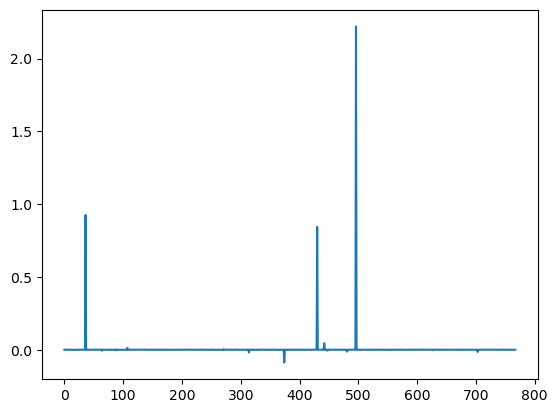

In [45]:
plt.plot(-pinvWai @ np.ones(50257))

In [28]:
outputs.hidden_states[-1][:,10,:].shape

torch.Size([1, 768])

In [29]:
logits_test = logits_from_hidden(outputs.hidden_states[-1][:,10,:])
torch.max(get_probability_distribution(logits_test))

tensor(0.9385, grad_fn=<MaxBackward1>)

In [30]:
hidden_peak0 = torch.ones_like(outputs.hidden_states[-1][:,10,:])
hidden_peak0 = hidden_peak0 * 1e-6
hidden_peak0[0,peak_indices[0]] = 1.0

In [31]:
torch.max(get_probability_distribution(logits_from_hidden(hidden_peak0)))

tensor(2.0023e-05, grad_fn=<MaxBackward1>)

In [32]:
logits_test = logits_from_hidden(outputs.hidden_states[-1][:,10,:])
torch.max(get_probability_distribution(logits_test))

tensor(0.9385, grad_fn=<MaxBackward1>)

In [33]:


def analyze_peaks(accumulated_counts, model, tokenizer, top_k=5):
    # Get the top k indices of the last layer's accumulated counts
    last_layer_counts = accumulated_counts[-1]
    peak_values, peak_indices = torch.topk(last_layer_counts, k=top_k)

    # Get the model's embedding weight
    embedding_weight = model.get_input_embeddings().weight
    unembed = embedding_weight.transpose(0, 1)

    # Define a function to convert hidden states to logits
    def logits_from_hidden(hidden_states, unembed=unembed):
        logits_from_hidden_state = hidden_states @ unembed
        return logits_from_hidden_state
    
    # Loop over each peak index
    for i, peak_index in enumerate(peak_indices):
        # Create a one-hot encoded vector for the peak
        one_hot = torch.zeros_like(last_layer_counts)
        one_hot[peak_index] = 1.0

        # Unembed the one-hot vector to get the logits
        logits = logits_from_hidden(one_hot.unsqueeze(0), unembed=unembed)

        # Convert logits to probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get the top k tokens from the probabilities
        top_values, top_token_indices = torch.topk(probabilities, k=top_k)

        # Convert the token indices to tokens
        tokens = [tokenizer.decode([int(index)], skip_special_tokens=True) for index in top_token_indices[0]]

        # Print the results
        print(f"Peak {i+1} at index {peak_index.item()} has the following top {top_k} tokens:")
        for value, token in zip(top_values[0], tokens):
            print(f"    {token} (prob: {value.item():.6f})")

# Call the function with the accumulated counts, model, and tokenizer
analyze_peaks(accumulated_counts, model, tokenizer)


Peak 1 at index 496 has the following top 5 tokens:
    ModLoader (prob: 0.000020)
     misunder (prob: 0.000020)
     occas (prob: 0.000020)
    accompan (prob: 0.000020)
     cryst (prob: 0.000020)
Peak 2 at index 430 has the following top 5 tokens:
     Citiz (prob: 0.000020)
     Pengu (prob: 0.000020)
     Vaugh (prob: 0.000020)
     Adin (prob: 0.000020)
     agre (prob: 0.000020)
Peak 3 at index 36 has the following top 5 tokens:
    aeper (prob: 0.000020)
    �� (prob: 0.000020)
    anamo (prob: 0.000020)
    �� (prob: 0.000020)
    �� (prob: 0.000020)
Peak 4 at index 442 has the following top 5 tokens:
    ricanes (prob: 0.000023)
    emetery (prob: 0.000023)
    agascar (prob: 0.000022)
    ═ (prob: 0.000022)
    osponsors (prob: 0.000022)
Peak 5 at index 107 has the following top 5 tokens:
    �� (prob: 0.000025)
    �� (prob: 0.000025)
    �� (prob: 0.000025)
    �� (prob: 0.000025)
    �� (prob: 0.000025)


**Seems that peaks in isolation are pretty meaningless.**

# TODO
- understand what are the peaks
- try to find the basis by clustering many outputs
- try to find unembed matrix that meaningfully unembeds hidden states
- or use the basis to make a linear combination of a hidden state into basis states and then unembed